In [1]:
import kimports; reload(kimports); from kimports import *
import kutils; reload(kutils);
%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
train_path, valid_path, test_path, resource_path = kutils.get_paths('../data/statefarm')

In [3]:

# Create vgg model
def vgg_preprocess(x):
    # Magic numbers that were the RGB averages of all Imagenet images
    mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
    x = x - mean
    return x[:, ::-1] # reverse from RGB to BGR
model = keras.models.Sequential()
model.add(keras.layers.core.Lambda(vgg_preprocess, input_shape=(3,224,224)))

# VGG16 layer configuration.
for layers, filters in [(2,64), (2,128), (3,256), (3,512), (3,512)]:
    for i in range(layers):
        model.add(keras.layers.convolutional.ZeroPadding2D((1, 1)))
        model.add(keras.layers.convolutional.Convolution2D(filters, 3, 3, activation='relu'))
    model.add(keras.layers.convolutional.MaxPooling2D((2, 2), strides=(2, 2)))

# This just reshapes the outputs of previous nodes into a 1 dimensional thing?
# TODO
model.add(keras.layers.core.Flatten())

# Add 2 fully connected layers
# TODO why?
model.add(keras.layers.core.Dense(4096, activation='relu'))
model.add(keras.layers.core.Dropout(0.5))
model.add(keras.layers.core.Dense(4096, activation='relu'))
model.add(keras.layers.core.Dropout(0.5))

# Add a final 1000 node layer for all 1000 Imagenet categories
model.add(keras.layers.core.Dense(1000, activation='softmax'))

# Load weights pre-trained by the vgg folks. Since we defined exactly the vgg architecture,
# we can reuse what they did before
model.load_weights(
    keras.utils.data_utils.get_file(
        'vgg16.h5',
        'http://www.platform.ai/models/vgg16.h5',
        cache_subdir='models'))

In [4]:
# Tweak final dense layers for state farm
model.pop()
for layer in model.layers: layer.trainable = False
model.add(keras.layers.core.Dense(10, activation='softmax'))
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.1),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [5]:
def last_conv_idx(model):
    return [i for i, layer in enumerate(model.layers)
            if type(layer) is keras.layers.convolutional.Convolution2D][-1]
def get_conv_layers(model):
    return model.layers[:last_conv_idx(model)+1]
def get_fc_layers(model):
    return model.layers[last_conv_idx(model) + 1:]
def save_features_for_model(model, batches, filename):
    features = model.predict_generator(batches, batches.nb_sample)
    bcolz.carray(features, rootdir=filename, mode='w').flush()
def load_features(filename):
    return bcolz.open(filename)[:]
def copy_weights(src, dest, iff=None):
    if len(src.layers) != len(dest.layers):
        raise Exception()
    for l1, l2 in zip(src.layers, dest.layers):
        if iff != None and iff(l1, l2):
            l2.set_weights(l1.get_weights())

In [6]:
# just dense
fc_model = keras.models.Sequential([
    keras.layers.convolutional.MaxPooling2D(input_shape=get_conv_layers(model)[-1].output_shape[1:]),
    keras.layers.core.Flatten(),
    keras.layers.core.Dense(4096, activation='relu'),
    keras.layers.core.Dropout(0.3),
    keras.layers.normalization.BatchNormalization(),
    keras.layers.core.Dense(4096, activation='relu'),
    keras.layers.core.Dropout(0.5),
    keras.layers.normalization.BatchNormalization(),
    keras.layers.core.Dense(10, activation='softmax')
    ])
for layer in fc_model.layers: layer.trainable=True
#fc_model.layers[-1].trainable=True
#copy_weights(keras.models.Sequential(get_fc_layers(model)), fc_model.layers)
fc_model.compile(
    #optimizer=keras.optimizers.Adam(lr=0.00001),
    optimizer=keras.optimizers.RMSprop(lr=0.00001, rho=0.7),
    loss='categorical_crossentropy',
    metrics=['accuracy'])



In [45]:
conv_model = keras.models.Sequential(get_conv_layers(model))
conv_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [6]:
# add the last convolutional layer
fc_conv_model = keras.models.Sequential([
    #keras.layers.normalization.BatchNormalization(input_shape=get_conv_layers(model)[-4].output_shape[1:]),
    #keras.layers.convolutional.Convolution2D(512, 3, 3, activation='relu'),
    #keras.layers.convolutional.ZeroPadding2D((1,1)),
    #keras.layers.normalization.BatchNormalization(),
    #keras.layers.convolutional.Convolution2D(512, 3, 3, activation='relu'),
    #keras.layers.convolutional.ZeroPadding2D((1,1)),
    #keras.layers.normalization.BatchNormalization(),
    keras.layers.convolutional.Convolution2D(512, 3, 3, activation='relu', input_shape=get_conv_layers(model)[-2].output_shape[1:]),
    keras.layers.convolutional.MaxPooling2D((2, 2), strides=(2, 2)),
    keras.layers.core.Flatten(),
    keras.layers.core.Dense(4096, activation='relu'),
    keras.layers.core.Dropout(0.5),
    keras.layers.normalization.BatchNormalization(),
    keras.layers.core.Dense(4096, activation='relu'),
    keras.layers.core.Dropout(0.5),
    keras.layers.normalization.BatchNormalization(),
    keras.layers.core.Dense(10, activation='softmax')
    ])
#for layer in fc_conv_model.layers: layer.trainable=True
#for l1, l2 in zip([get_conv_layers(model)[-1]] + fc_conv_model.layers, fc_conv_model2.layers):
#    l2.set_weights(l1.get_weights())
fc_conv_model.compile(
    #optimizer=keras.optimizers.Adam(lr=0.00001),
    optimizer=keras.optimizers.RMSprop(lr=0.0001, rho=0.7),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [7]:
fc_conv_model.load_weights(resource_path+'/fc_conv_weights_03_05.9527.h5')

In [6]:
# add the last convolutional layer
fc_conv_model3 = keras.models.Sequential([
    #keras.layers.normalization.BatchNormalization(input_shape=get_conv_layers(model)[-4].output_shape[1:]),
        
    keras.layers.convolutional.Convolution2D(512, 3, 3, activation='relu', input_shape=get_conv_layers(model)[-4].output_shape[1:]),
    keras.layers.convolutional.ZeroPadding2D((1,1)),
    keras.layers.convolutional.Convolution2D(512, 3, 3, activation='relu'),
    keras.layers.convolutional.ZeroPadding2D((1,1)),
    keras.layers.convolutional.Convolution2D(512, 3, 3, activation='relu'),
    keras.layers.convolutional.MaxPooling2D((2, 2), strides=(2, 2)),
    keras.layers.core.Flatten(),
    keras.layers.core.Dense(4096, activation='relu'),
    keras.layers.core.Dropout(0.5),
    keras.layers.normalization.BatchNormalization(),
    keras.layers.core.Dense(4096, activation='relu'),
    keras.layers.core.Dropout(0.5),
    keras.layers.normalization.BatchNormalization(),
    keras.layers.core.Dense(10, activation='softmax')
    ])
#for layer in fc_conv_model3.layers: layer.trainable=True
#for l1, l2 in zip(get_conv_layers(model)[-3:-1] + fc_conv_model.layers, fc_conv_model3.layers):
#    l2.set_weights(l1.get_weights())
fc_conv_model3.compile(
    #optimizer=keras.optimizers.Adam(lr=0.00001),
    optimizer=keras.optimizers.RMSprop(lr=0.00001, rho=0.7),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [7]:
fc_conv_model3.load_weights(resource_path+'/fc_conv3_weights_05_05.9527.h5')

In [9]:
# Missing the last 1 convolution
conv_model = keras.models.Sequential(get_conv_layers(model)[:-1])
conv_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [8]:
train_batches = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=.15,
    height_shift_range=.15,
    shear_range=0.5,
    channel_shift_range=15,
).flow_from_directory(train_path, shuffle=False, target_size=(224,224), batch_size=128)
valid_batches = keras.preprocessing.image.ImageDataGenerator(
).flow_from_directory(valid_path, shuffle=False, target_size=(224,224), batch_size=128)
test_batches = keras.preprocessing.image.ImageDataGenerator(
).flow_from_directory(test_path, shuffle=False, target_size=(224,224), batch_size=128)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


In [14]:
%%time
save_features_for_model(conv_model, train_batches, resource_path + "/conv_train_features_minus2conv.bc")

CPU times: user 50.5 s, sys: 6.36 s, total: 56.8 s
Wall time: 29.8 s


In [15]:
%%time
save_features_for_model(conv_model, valid_batches, resource_path + "/conv_valid_features_minus2conv.bc")

CPU times: user 48.6 s, sys: 6.13 s, total: 54.7 s
Wall time: 27.3 s


In [10]:
%%time
save_features_for_model(conv_model, test_batches, resource_path + "/conv_test_features_minus1conv.bc")

CPU times: user 50min 23s, sys: 7min 47s, total: 58min 11s
Wall time: 35min 59s


In [9]:
#train_features = load_features(resource_path + "/conv_train_features_minus1conv.bc")
#valid_features = load_features(resource_path + "/conv_valid_features_minus1conv.bc")
test_features = load_features(resource_path + "/conv_test_features_minus1conv.bc")

In [ ]:
fc_conv_model.fit(train_features, kutils.onehot(train_batches), nb_epoch=1, batch_size=1500,
                        validation_data=(valid_features, kutils.onehot(valid_batches)),
                    shuffle=False)

In [ ]:
for i in range(100):
    fc_conv_model3.fit(train_features, kutils.onehot(train_batches), nb_epoch=10, batch_size=1500,
                        validation_data=(valid_features, kutils.onehot(valid_batches)),
                    shuffle=False)
    name=resource_path + '/fc_conv3_weights_05_05.' + str(i) + '.h5'
    print name
    fc_conv_model.save_weights(name)

In [25]:
def images_from_batches(batches, n):
    return [batches.next()[0].astype(np.uint8)[0] for _ in range(n)]

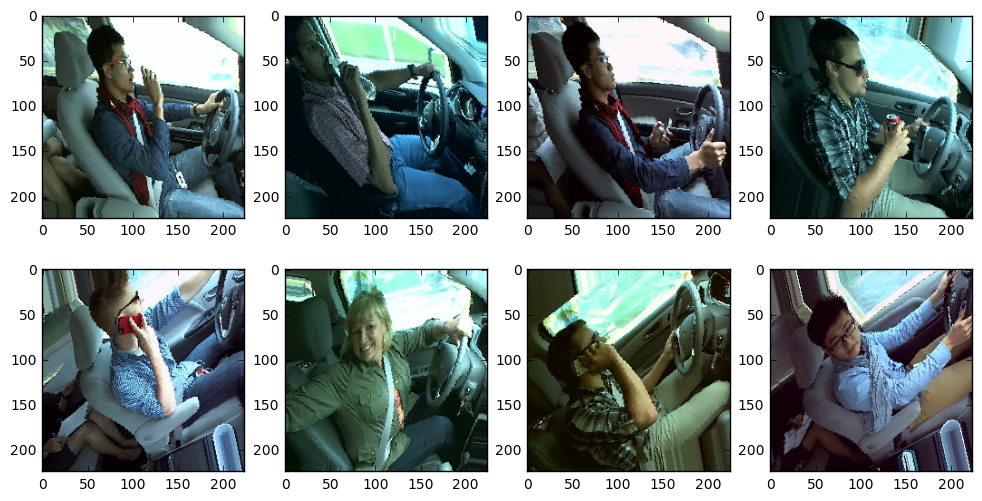

In [32]:
kutils.plot_images(images_from_batches(train_batches, 8))

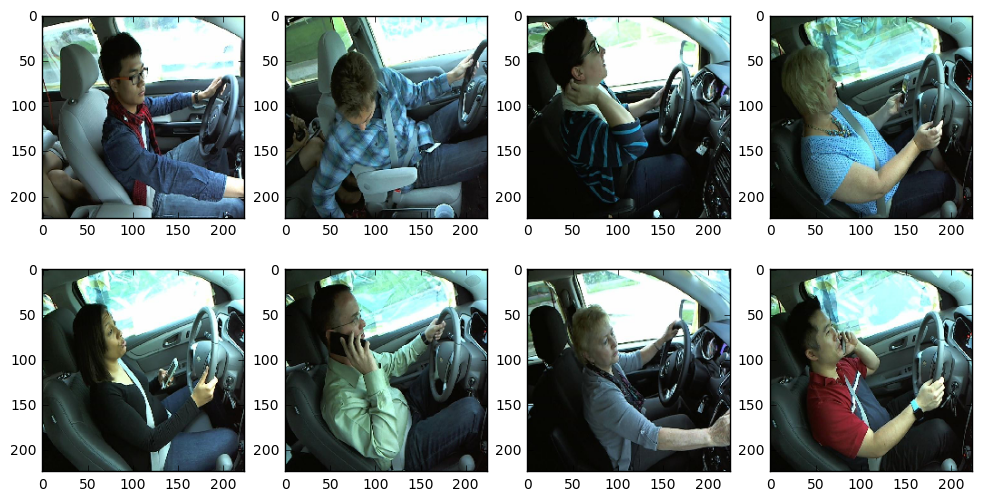

In [33]:
kutils.plot_images(images_from_batches(valid_batches, 8))

In [11]:
preds = fc_conv_model.predict(test_features, batch_size=1024)

In [29]:
kutils.multiclass_logloss_rowscaled(valid_batches, preds)

0.17111934259921188

In [17]:
# Generate CSV
sorted_indices = sorted(train_batches.class_indices)
header = ','.join(['img'] + [i for i in sorted(train_batches.class_indices)])
with open('../data/statefarm/results' + '/results.csv', 'w') as f:
    f.write(header + '\n')
    for filename, prow in zip(test_batches.filenames, preds):
        f.write(filename.replace('unknown/','') + ',' + ','.join(map(str, prow)) + '\n')